# HW7 2021300003004 张天骏

## 第一问

将约束条件带入优化问题得到：$$ v(a)=\underset{a' }{ \max } [\ln (c)+\beta v(a')]  $$

## 第二问

In [74]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

### a

In [75]:
beta = 0.95
w=1
r=0.03
kmin = 0
kmax = 5
n = 500
kgrid = np.linspace(kmin, kmax, n)

In [76]:
def u(c):
    if c > 0:
        res = np.log(c)
    else:
        res = -np.inf
    return res


def budget(k, c): #唯一需要更改的内容
    return w + (1+r)*k - c


def V_current(k, k_next, V_next):
    c = budget(k, k_next)
    res = u(c) + beta * V_next
    return res


def V_max(k_index, k_start, V):
    k = kgrid[k_index]
    k_bound = budget(k, 0)  # keep non-zero consumption
    V_max = -np.inf  # initialize maximum value
    g_k=0
    # loop over possible k_next
    for j in range(k_start, n):
        k_next = kgrid[j]
        V_next = V[j]
        if k_next < k_bound:  # check feasibility with
            V_new = V_current(k, k_next, V_next)
            if V_new > V_max:
                V_max = V_new
                k_start = j
                g_k = k_next
            else:
                break
    return V_max, g_k, k_start


def V_update(V):
    # initialize updated value function and policy function
    V_new = np.zeros(n)
    g_new = np.zeros(n)
    k_start = 0
    # loop over grid points
    for i in range(n):
        V_new[i], g_new[i], k_start = V_max(i, k_start, V)
    return V_new, g_new


def V_iteration(V_initial):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    tol = 1e-6

    while count < max_iter and error > tol:
        V_new, g_new = V_update(V)
        error = np.nanmax(np.abs(V_new - V))
        V = V_new
        count = count + 1

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new

In [77]:
V0 = np.zeros(n)
start_time = timeit.default_timer()
V, g = V_iteration(V0)
print("The time difference is :", timeit.default_timer() - start_time)


Converged in 23 iterations.
The time difference is : 0.1030898999999863


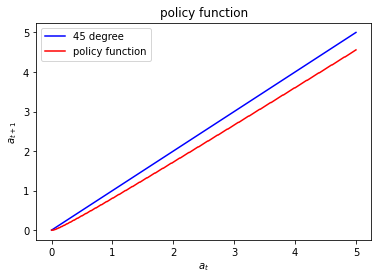

In [78]:
plt.plot(kgrid,kgrid,label='45 degree',color='blue')
plt.plot(kgrid,g,label='policy function',color='red')
plt.xlabel('$a_t$')
plt.ylabel('$a_{t+1}$')
plt.title('policy function')
plt.legend()

### b


Converged in 23 iterations.

Converged in 200 iterations.

Converged in 232 iterations.


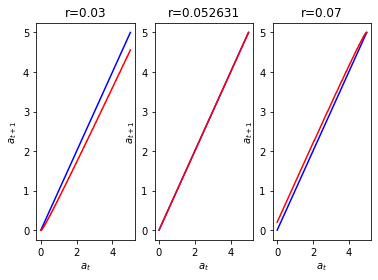

In [79]:
r0=[0.03, 0.052631, 0.07]
# 0.052631=(1/beta)-1 iff c_{t+1}/c_{t}=1  Euler Equation
plt.subplots(1,3)
for i in range(3):
    beta = 0.95
    w=1
    r=r0[i]
    kmin = 0
    kmax = 5
    n = 500
    kgrid = np.linspace(kmin, kmax, n)
    V0 = np.zeros(n)
    V, g = V_iteration(V0)
    plt.subplot(1,3,i+1)
    plt.plot(kgrid,kgrid,color='blue')
    plt.plot(kgrid,g,color='red')
    plt.xlabel('$a_t$')
    plt.ylabel('$a_{t+1}$')
    plt.title('r='+ str(r0[i]))

以上三个图像中的红色线展示了储蓄对策函数在不同利率条件下的图像，可以发现$r=0.52631$时，对策曲线和45度线重合，可以推断此时任何储蓄决策都是稳定的；$r=0.03$时，对策曲线在45度线下面，可以推断此时任何储蓄决策最终都会收敛到0，即不储蓄；$r=0.07$时，对策曲线在45度线上面，可以推断此时任何储蓄决策最终都会收敛到5，即尽可能多的储蓄。这反映出个人在储蓄决策中面对的未来消费增加和本期消费减少之间的权衡。


### c


Converged in 23 iterations.

Converged in 235 iterations.

Converged in 3 iterations.


C:\Users\90448\AppData\Local\Temp\ipykernel_17648\830409633.py:59: RuntimeWarning: invalid value encountered in subtract
  error = np.nanmax(np.abs(V_new - V))
C:\Users\90448\AppData\Local\Temp\ipykernel_17648\830409633.py:59: RuntimeWarning: All-NaN slice encountered
  error = np.nanmax(np.abs(V_new - V))


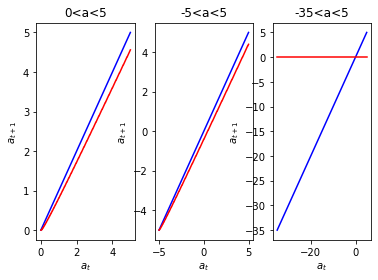

In [80]:
a0=np.array([[0,5],[-5,5],[-35,5]])
plt.subplots(1,3)
for i in range(3):
    beta = 0.95
    w=1
    r=0.03
    kmin = a0[i,0]
    kmax = a0[1,1]
    n = 500
    kgrid = np.linspace(kmin, kmax, n)
    V0 = np.zeros(n)
    V, g = V_iteration(V0)
    plt.subplot(1,3,i+1)
    plt.plot(kgrid,kgrid,color='blue')
    plt.plot(kgrid,g,color='red')
    plt.xlabel('$a_t$')
    plt.ylabel('$a_{t+1}$')
    plt.title(str(a0[i,0])+'<'+'a'+'<'+str(a0[i,1]))
    


当$-35<a<5$时，由于自然债务下限$=-w/r=-100/3$，可行域超出下限，使得求解无意义。所以我在$V_{max}$函数添加了一个约束，要求$k$不小于自然债务下限：

C:\Users\90448\AppData\Local\Temp\ipykernel_17648\2026200305.py:43: RuntimeWarning: invalid value encountered in subtract
  error = np.nanmax(np.abs(V_new - V))



Converged in 310 iterations.


Text(0.5, 1.0, '-35<a<5')

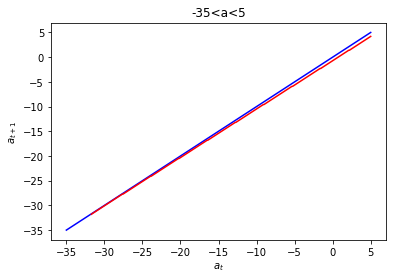

In [81]:
#在基础代码上加补丁patch
def V_max1(k_index, k_start, V):
    k = kgrid[k_index]
    k_bound = budget(k, 0)  # keep non-zero consumption
    V_max = -np.inf  # initialize maximum value
    # loop over possible k_next
    g_k = 0
    for j in range(k_start, n):
        k_next = kgrid[j]
        V_next = V[j]
        if k_next < k_bound and k_next >= -w/r:  # check feasibility with natural loan limit
            V_new = V_current(k, k_next, V_next)
            if V_new > V_max:
                V_max = V_new
                k_start = j
                g_k = k_next
            else:
                break
        else:g_k=-np.inf
    return V_max, g_k, k_start


def V_update1(V):
    # initialize updated value function and policy function
    V_new = np.zeros(n)
    g_new = np.zeros(n)
    k_start = 0
    # loop over grid points
    for i in range(n):
        V_new[i], g_new[i], k_start = V_max1(i, k_start, V)
    return V_new, g_new


def V_iteration1(V_initial):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    tol = 1e-6

    while count < max_iter and error > tol:
        V_new, g_new = V_update1(V)
        error = np.nanmax(np.abs(V_new - V))
        V = V_new
        count = count + 1

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new

beta = 0.95
w=1
r=0.03
kmin =-35
kmax = 5
n = 500
kgrid = np.linspace(kmin, kmax, n)
V0 = np.zeros(n)
V, g = V_iteration1(V0)
plt.plot(kgrid,kgrid,color='blue')
plt.plot(kgrid,g,color='red')
plt.xlabel('$a_t$')
plt.ylabel('$a_{t+1}$')
plt.title('-35<a<5')

### d

此时由于借贷的利率不同，约束条件取决于$a_t$的正负。所以我基于此修改$\mathrm{budget}$函数适应这一条件：

In [82]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

beta = 0.95
w=1
r_saving=0.03
r_borrowing=0.1
kmin = -5
kmax = 5
n = 500
kgrid = np.linspace(kmin, kmax, n)

def u(c):
    if c > 0:
        res = np.log(c)
    else:
        res = -np.inf
    return res


def budget(k, c):
    if k>0:
        return w + (1+r_saving)*k - c
    else:
        return w + (1+r_borrowing)*k - c

def V_current(k, k_next, V_next):
    c = budget(k, k_next)
    res = u(c) + beta * V_next
    return res


def V_max(k_index, k_start, V):
    k = kgrid[k_index]
    k_bound = budget(k, 0)  # keep non-zero consumption
    V_max = -np.inf  # initialize maximum value
    # loop over possible k_next
    for j in range(k_start, n):
        k_next = kgrid[j]
        V_next = V[j]
        if k_next < k_bound:  # check feasibility
            V_new = V_current(k, k_next, V_next)
            if V_new > V_max:
                V_max = V_new
                g_k = k_next
                k_start = j
            else:
                break
    return V_max, g_k, k_start


def V_update(V):
    # initialize updated value function and policy function
    V_new = np.zeros(n)
    g_new = np.zeros(n)
    k_start = 0
    # loop over grid points
    for i in range(n):
        V_new[i], g_new[i], k_start = V_max(i, k_start, V)
    return V_new, g_new


def V_iteration(V_initial):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    tol = 1e-6

    while count < max_iter and error > tol:
        V_new, g_new = V_update(V)
        error = np.nanmax(np.abs(V_new - V))
        V = V_new
        count = count + 1

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new

V0 = np.zeros(n)
start_time = timeit.default_timer()
V, g = V_iteration(V0)
print("The time difference is :", timeit.default_timer() - start_time)


Converged in 238 iterations.
The time difference is : 1.4850475000000642


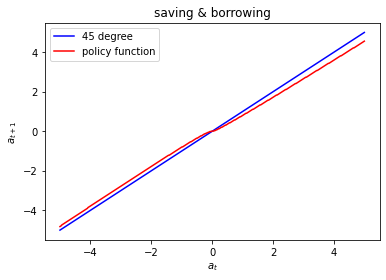

In [83]:
plt.plot(kgrid,kgrid,label='45 degree',color='blue')
plt.plot(kgrid,g,label='policy function',color='red')
plt.xlabel('$a_t$')
plt.ylabel('$a_{t+1}$')
plt.title('saving & borrowing')
plt.legend()

此时，当$a>0$时，和(c)中第一张图的情况一样，任何储蓄决策都会减少自己的储蓄，收敛到0，即不储蓄；当$a<0$时，由于较高的利率，和(c)中第三张图的情况类似，任何借贷决策都会减少自己的借贷，收敛到0，即不借贷。所以，$a=0$是一个稳定的稳态

### e


Converged in 312 iterations.


Text(0.5, 1.0, '1e-2<a<5')

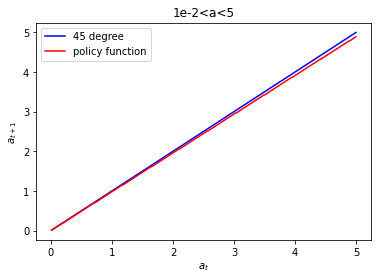

In [84]:
beta=0.95
w=0
r=0
kmin = 1e-2
kmax = 5
n = 500
kgrid = np.linspace(kmin, kmax, n)
V0 = np.zeros(n)
V, g = V_iteration(V0)
plt.plot(kgrid,kgrid,label='45 degree',color='blue')
plt.plot(kgrid,g,label='policy function',color='red')
plt.xlabel('$a_t$')
plt.ylabel('$a_{t+1}$')
plt.legend()
plt.title('1e-2<a<5')